<a href="https://colab.research.google.com/github/Youjian-Huang/ALY_6110_Assignment/blob/main/Module_5_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, stddev, min, max, col, corr, avg
#spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder.master("local[*]").enableHiveSupport().getOrCreate()

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Load data into a DataFrame
file_path = "/content/BostonHousing.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
# Create a temporary view for Spark SQL queries
df.createOrReplaceTempView("BostonHousing_1")

# Task1: Overview

In [25]:
# Retrieve and display the first 5 rows of the dataset to get a sense of the data's structure.
spark.sql("SELECT * FROM BostonHousing_1").show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



# Task2:Summary the data

In [21]:
# Summary Descripyive Statistics of the data set
df.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              crim|                zn|             indus|              chas|                nox|                rm|               age|              dis|              rad|               tax|           ptratio|                 b|             lstat|              medv|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|               506|               506|               506|               506|                506|               506|               506|              506|              

# Task3:Combine features to a single vector columns using VectorAssembler

In [26]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Define the features and target
only_features = df.columns[:-1]
assembler = VectorAssembler(inputCols=only_features, outputCol="features")
df = assembler.transform(df)
df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|            features|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|[0.00632,18.0,2.3...|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|[0.02731,0.0,7.07...|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|[0.02729,0.0,7.07...|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|[0.03237,0.0,2.18...|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|[0.06905,0.0,2.18...|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+
only showing top 5 rows



# Task4:Standardize features for principal component analysis

In [27]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(df)
df = scalerModel.transform(df)
df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+--------------------+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|            features|      scaledFeatures|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+--------------------+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|[0.00632,18.0,2.3...|[-0.4193669292132...|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|[0.02731,0.0,7.07...|[-0.4169266699640...|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|[0.02729,0.0,7.07...|[-0.4169289951277...|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|[0.03237,0.0,2.18...|[-0.4163384035610...|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|[0.06905,0.0,2.18...|[-0.4120740534

# Task4:Train model for two principal component analysis

In [28]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pcaModel = pca.fit(df)
df = pcaModel.transform(df)
df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+--------------------+--------------------+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|            features|      scaledFeatures|         pcaFeatures|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+--------------------+--------------------+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|[0.00632,18.0,2.3...|[-0.4193669292132...|[2.09622303023858...|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|[0.02731,0.0,7.07...|[-0.4169266699640...|[1.45581098944742...|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|[0.02729,0.0,7.07...|[-0.4169289951277...|[2.07254655194818...|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|[0.03237,0.0,2.18...|[-0.4163384035

# Task5: Collect distributed data in numpy array and convert to pandas dataframe

In [30]:
from pyspark.ml.feature import PCA

# Collect distributed data to a local pandas DataFrame
pca_data = df.select("pcaFeatures").collect()
pca_data = [row.pcaFeatures.toArray() for row in pca_data]
import numpy as np
pca_data = np.array(pca_data)
pca_data


array([[2.09622303, 0.77234843],
       [1.45581099, 0.59139995],
       [2.07254655, 0.59904658],
       ...,
       [0.31205166, 1.15410433],
       [0.27025162, 1.04033206],
       [0.12567884, 0.76122473]])

In [31]:
# Convert to pandas DataFrame
pca_df = pd.DataFrame(pca_data, columns=["PC1", "PC2"])
pca_df.head(10)

,PC1,PC2
0,2.096223,0.772348
1,1.455811,0.591400
2,2.072547,0.599047
3,2.608922,-0.006864
4,2.455755,0.097615
5,2.212662,-0.009478
6,1.357538,0.349526
7,0.841212,0.577228
8,0.179750,0.342180
9,1.073122,0.315889


# Task6:Step 6: Plot the Two Principal Components

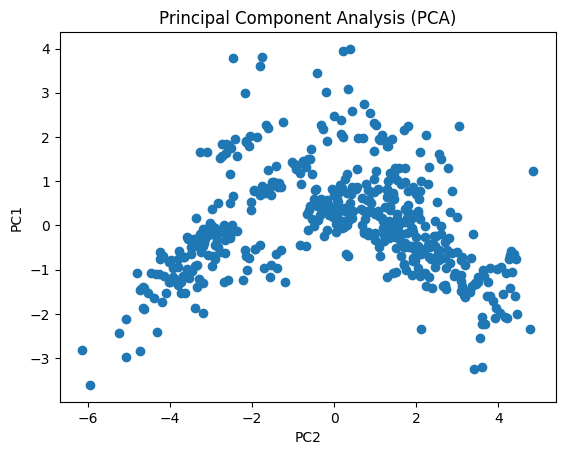

In [32]:
import matplotlib.pyplot as plt

plt.scatter(pca_df["PC1"], pca_df["PC2"])
plt.xlabel("PC2")
plt.ylabel("PC1")
plt.title("Principal Component Analysis (PCA)")
plt.show()

# Task7:Vectorize Features and Target Together

In [38]:
vect_df = df.select("features", "medv")

vect_df.show()

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
|[0.02985,0.0,2.18...|28.7|
|[0.08829,12.5,7.8...|22.9|
|[0.14455,12.5,7.8...|27.1|
|[0.21124,12.5,7.8...|16.5|
|[0.17004,12.5,7.8...|18.9|
|[0.22489,12.5,7.8...|15.0|
|[0.11747,12.5,7.8...|18.9|
|[0.09378,12.5,7.8...|21.7|
|[0.62976,0.0,8.14...|20.4|
|[0.63796,0.0,8.14...|18.2|
|[0.62739,0.0,8.14...|19.9|
|[1.05393,0.0,8.14...|23.1|
|[0.7842,0.0,8.14,...|17.5|
|[0.80271,0.0,8.14...|20.2|
|[0.7258,0.0,8.14,...|18.2|
+--------------------+----+
only showing top 20 rows



# Task8:Split dataset into training and testing dataset

In [39]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Task9:Fit model for linear regression

In [40]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="medv")
lr_model = lr.fit(train_df)

# Task10:Find out model coefficients and intercept

In [41]:
# Model coefficients and intercept
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

Coefficients: [-0.1136220372940893,0.04890918693405423,0.02379542898673218,2.8017719987351315,-18.41542454118947,3.5158797633119243,0.005211682161471423,-1.416383072353979,0.33176693159370374,-0.013607893704163855,-0.9534143338408103,0.008602677392853194,-0.5195035312476691]
Intercept: 38.61699144573505


# Task11:Evaluate model for test dataset

In [35]:
test_results = lr_model.evaluate(test_df)
print(f"RMSE: {test_results.rootMeanSquaredError}")
print(f"R2: {test_results.r2}")

RMSE: 4.671806485171292
R2: 0.7931522547835961


# Task12:Perform further analysis for better interpretation of model results.

R-squared: 0.7931522547835961
Adjusted R-squared: 0.7414403184794951


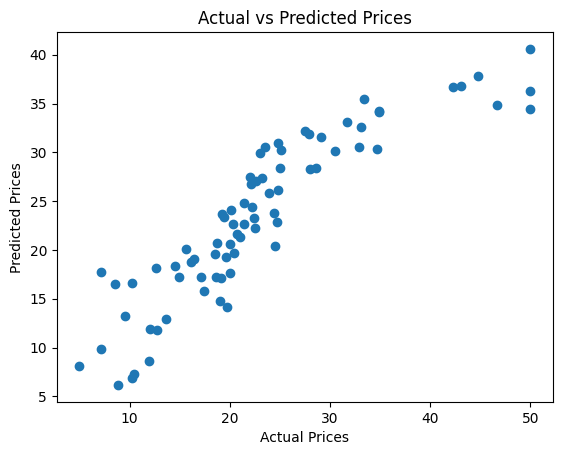

In [49]:
# Predicting on test data
test_results = lr_model.evaluate(test_df)

# Calculate R-squared
r2 = test_results.r2
print(f"R-squared: {r2}")

# Calculate Adjusted R-squared
n = test_df.count()  # Number of observations
p = len(test_df.columns) - 2  # Number of predictors (subtracting 'label' and 'features' columns)

adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
print(f"Adjusted R-squared: {adjusted_r2}")

#Plot Predicted vs Actual Values:
predictions = lr_model.transform(test_df)
predictions_df = predictions.select("prediction", "medv").toPandas()

import matplotlib.pyplot as plt
plt.scatter(predictions_df["medv"], predictions_df["prediction"])
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()


# Summary
**R-Squared and ajusted R-Squared:** The linear regression model for predicting the median value of homes (medv) performs well, with an R-squared (R²) value of 0.7932. This means the model explains about 79.32% of the variability in home prices, indicating a good fit. The Adjusted R-squared (Adjusted R²) value is 0.7414, which adjusts the R-squared based on the number of predictors to account for potential overfitting. This slightly lower value shows the model still fits well, but with a more cautious estimate considering the model's complexity.


**"Actual vs Predicted Prices" plot:** In addition, the scatter plot "Actual vs Predicted Prices" also shows that most points are close to the 45-degree line indicates that the model's predictions are generally accurate.